In [1]:
cd /home/andre/Projects/stocks/

/home/andre/Projects/stocks


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
from Tools.util import progressbar
from Tools import prepareData, torchNN
from Tools import meta5Ibov

In [3]:
# Working Path for Expert Advisor Metatrader 5
# Use same path that can be read by the expert advisor
datapath = '/home/andre/Projects/stocks/data'
os.chdir(datapath)
# statistical mean and variance from 2013+2018 used to make data
# with variance < 1 and mean close to 0, that is how it works!
stocks_stats = pd.read_csv('stocks_stats_2018.csv', index_col=0)
# selected columns by backtesting best performance accuracy
with open('collumns_selected.txt', 'r') as f: # txt column names divided by spaces
    columns = f.read()
selected_columns = columns.split(' ')[:-1]
#datapath = '/home/andre/.wine/drive_c/Program Files/Rico MetaTrader 5/MQL5/Files'
meta5Ibov.setDataPath(datapath, datapath, verbose=False)
# don't want masterdf to be reused
masterdf = meta5Ibov.loadMeta5Data(suffix='M1.mt5bin',
            cleandays=True, preload=False, verbose=True)
masterdf = meta5Ibov.simpleColumnNames()

Symbols loaded:
['PETR4' 'BBDC4' 'VALE3' 'DOL$' 'ITUB4' 'WIN@' 'B3SA3' 'BBAS3' 'ABEV3']
percent missing:  0.02973624520526797


In [4]:
len(masterdf)

505242

In [5]:
device = torchNN.getDevice()

In [6]:
import torch as th
import random
seed=10
np.random.seed(seed)
if str(device) == 'cuda':
    th.backends.cudnn.deterministic = True
random.seed(seed) # pytorch rely on random for weights
th.manual_seed(seed)

In [7]:
nwasted = 120+120+7  # number of lost samples due (shift + EMA's + unknown)
ntraining = 5*8*60 # 8 hours before for training
nscore = 120 # validation samples
nforecast = 120 # forecasting/prediction samples
nneed = ntraining+nscore+nforecast+nwasted # need number of samples
npredict = nscore + nforecast + ntraining # samples for predicting one direction
print(nneed, npredict)

2887 2640


In [8]:
start=320000
end=320003

In [9]:
prediction_book = np.zeros((3, 3))    
for i in progressbar(range(start, end)):
    X = masterdf[i-nneed:i]
    # effective missing data
    percmiss = meta5Ibov.calculateMissing(X)
    X, y, Xp = prepareData.GetTrainingPredictionVectors(
        X.copy(), targetsymbol='PETR4_C', verbose=False,
        selected=selected_columns, stats=stocks_stats)
    print(X.index[0])
    # classifier training and use
    buy = torchNN.TrainPredictDecide(X, y, Xp, verbose=True)
    print(Xp.index[-1])
#     device = torchNN.getDevice() # get cpu or cuda    
    if buy != 0:    
        prediction_book[j, 0] = i-1 # prediction time
        prediction_book[j, 1] = buy
        prediction_book[j, 2] = percmiss
        j = j + 1

2016-10-11 13:16:00..............................................................] 0/3
iteration :      0 l training: 0.73 l validation: 0.59 Err trainging :0.90  Err validation ; 0.275
iteration :      6 l training: 0.47 l validation: 0.59 Err trainging :0.16  Err validation ; 0.275
iteration :     12 l training: 0.50 l validation: 0.59 Err trainging :0.18  Err validation ; 0.275
iteration :     18 l training: 0.37 l validation: 0.59 Err trainging :0.06  Err validation ; 0.275
iteration :     24 l training: 0.56 l validation: 0.59 Err trainging :0.24  Err validation ; 0.275
 errort :  0.90234375  errorv:  0.2750000059604645  buy  0
2016-10-20 16:04:00
2016-10-11 13:17:00########......................................................] 1/3
iteration :      0 l training: 0.70 l validation: 0.59 Err trainging :0.66  Err validation ; 0.275
iteration :      6 l training: 0.32 l validation: 0.59 Err trainging :0.01  Err validation ; 0.275
iteration :     12 l training: 0.55 l validation: 0.59

In [14]:
prediction_book =prediction_book[:j]

In [15]:
dfprediction_book = pd.DataFrame(prediction_book, columns=['time', 'direction', 'percmiss'])

In [16]:
dfprediction_book["time"]= masterdf.iloc[dfprediction_book.time.values.astype(np.int32)].index

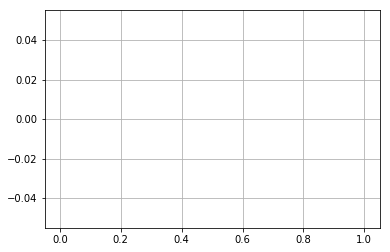

In [17]:
dfprediction_book.percmiss.hist(bins=40) 

In [18]:
dfprediction_book.to_pickle('daimon_backtesting_3_months_prediction_book.pickle')

In [19]:
pwd

'/home/andre/.wine/drive_c/Program Files/Rico MetaTrader 5/MQL5/Files'